# DOE 本番解析用

In [36]:
import os

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.interpolate import griddata
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.formula.api import ols

### Matplotlib の設定（オプション）

In [37]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 14

## CSV ファイルの読込

In [38]:
# データ読み込み
file_csv = "../logs/result_20251201162005.csv"
file_body = os.path.splitext(os.path.basename(file_csv))[
    0
]  # プロットの保存用ファイル名
df = pd.read_csv(file_csv)
df

,file,code,trade,PERIOD_MA_1,PERIOD_MA_2,PERIOD_MR,THRESHOLD_MR,total
0,ticks_20251127.xlsx,7011,100,30,300,15,1,-37.0
1,ticks_20251128.xlsx,7011,100,30,300,15,1,17.0
2,ticks_20251201.xlsx,7011,100,30,300,15,1,47.0
3,ticks_20251127.xlsx,7011,100,60,300,15,1,-68.0
4,ticks_20251128.xlsx,7011,100,60,300,15,1,-52.0
...,...,...,...,...,...,...,...,...
238,ticks_20251128.xlsx,7011,16,60,900,45,7,-3.0
239,ticks_20251201.xlsx,7011,14,60,900,45,7,20.0
240,ticks_20251127.xlsx,7011,10,90,900,45,7,-16.0
241,ticks_20251128.xlsx,7011,14,90,900,45,7,-18.0


## 分散分析 (ANOVA)

In [39]:
# オリジナルのデータフレームをコピーして利用
df_anova = df.copy()

# 因子をカテゴリ化
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2", "PERIOD_MR", "THRESHOLD_MR"]
for c in factor_cols:
    df_anova[c] = df_anova[c].astype("category")

# ANOVA（注視交互作用のみ）
formula = "total ~ C(PERIOD_MA_1)*C(PERIOD_MA_2) + C(PERIOD_MR)*C(THRESHOLD_MR)"
model = ols(formula, data=df_anova).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                      sum_sq     df          F        PR(>F)
C(PERIOD_MA_1)                    304.617284    2.0   0.269555  7.639641e-01
C(PERIOD_MA_2)                  21292.617284    2.0  18.841811  2.703069e-08
C(PERIOD_MR)                     4732.518519    2.0   4.187800  1.637393e-02
C(THRESHOLD_MR)                 39428.222222    2.0  34.889985  6.234240e-14
C(PERIOD_MA_1):C(PERIOD_MA_2)     743.876543    4.0   0.329128  8.582317e-01
C(PERIOD_MR):C(THRESHOLD_MR)     1484.444444    4.0   0.656792  6.226598e-01
Residual                       127698.222222  226.0        NaN           NaN


## 主効果＋交互作用 プロット

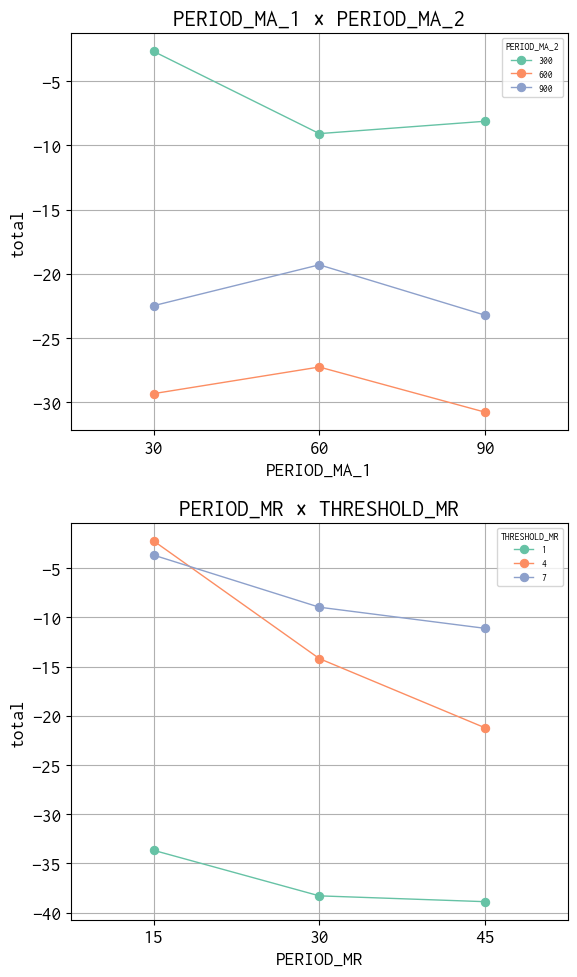

In [40]:
output = os.path.join("..", "logs", f"{file_body}_effects.png")

pairs = [
    ("PERIOD_MA_1", "PERIOD_MA_2"),
    ("PERIOD_MR", "THRESHOLD_MR"),
]

fig, axes = plt.subplots(2, 1, figsize=(6, 10))
for ax, (a, b) in zip(axes, pairs):
    sns.pointplot(
        x=a,
        y="total",
        hue=b,
        data=df,
        markersize=6,
        linewidth=1,
        errorbar=None,
        palette="Set2",
        ax=ax,
    )
    ax.set_title(f"{a} × {b}")
    ax.set_xlabel(a)
    ax.set_ylabel("total")
    lg = ax.legend(fontsize=7)
    lg.set_title(b, prop={"size": 7})
    ax.grid()

plt.tight_layout()
plt.savefig(output)
plt.show()

## 交互作用の等高線図

### Contour Map

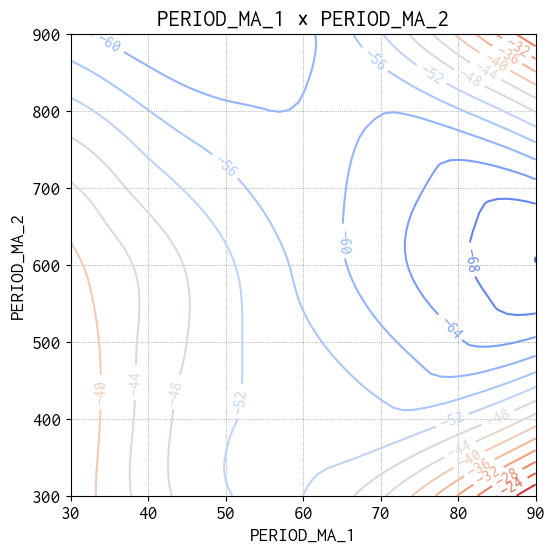

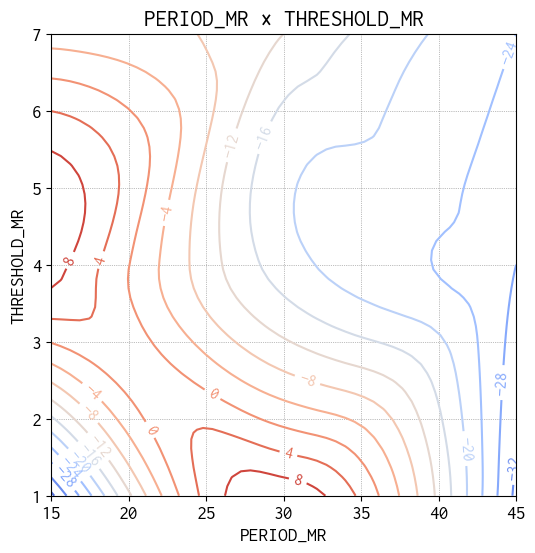

In [41]:
def plot_contour(col_x: str, col_y: str, col_z: str, output: str):
    x = df[col_x]
    y = df[col_y]
    z = df[col_z]

    # グリッド作成
    xi = np.linspace(x.min(), x.max(), 50)
    yi = np.linspace(y.min(), y.max(), 50)
    Xi, Yi = np.meshgrid(xi, yi)
    # 補間
    Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

    plt.figure(figsize=(6, 6))
    cont = plt.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm")
    plt.clabel(cont, inline=True, fontsize=12)
    plt.title(f"{col_x} × {col_y}")
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.grid(True, color="gray", linestyle="dotted", linewidth=0.5)
    plt.savefig(output)
    plt.show()


# ===== 1. PERIOD_MA_1 × PERIOD_MA_2 =====
output = os.path.join("..", "logs", f"{file_body}_contour_1.png")
plot_contour("PERIOD_MA_1", "PERIOD_MA_2", "total", output)
# ===== 2. PERIOD_MR × THRESHOLD_MR =====
output = os.path.join("..", "logs", f"{file_body}_contour_2.png")
plot_contour("PERIOD_MR", "THRESHOLD_MR", "total", output)

## 二次多項式と Lasso 回帰

In [44]:
# 1. 因子を数値として扱う
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2", "PERIOD_MR", "THRESHOLD_MR"]
X = df[factor_cols]
y = df["total"]

# 2. 二次回帰＋Lasso
poly = PolynomialFeatures(degree=2, include_bias=False)
lasso = LassoCV(cv=5, random_state=0)

model = make_pipeline(poly, lasso).fit(X, y)

# 3. サマリ統計
# 展開後の特徴量名を取得
feature_names = poly.get_feature_names_out(factor_cols)

# 係数を取り出し
coef = model.named_steps["lassocv"].coef_

# 結果をDataFrameにまとめる
summary = pd.DataFrame({"feature": feature_names, "coefficient": coef})

# 非ゼロ係数のみ表示
summary_nonzero = summary[summary["coefficient"] != 0]

print("=== Lassoによる選択結果（非ゼロ係数） ===")
print(summary_nonzero)

# モデル性能
y_pred = model.predict(X)
print("\nR^2:", r2_score(y, y_pred))
print("Best alpha (正則化パラメータ):", model.named_steps["lassocv"].alpha_)

=== Lassoによる選択結果（非ゼロ係数） ===
                     feature  coefficient
5    PERIOD_MA_1 PERIOD_MA_2    -0.000103
8              PERIOD_MA_2^2    -0.000020
9      PERIOD_MA_2 PERIOD_MR    -0.000620
10  PERIOD_MA_2 THRESHOLD_MR     0.007179

R^2: 0.256173893165923
Best alpha (正則化パラメータ): 1506.2962962962977


## 分散分析 (ANOVA) 再び - 全ての交互作用

In [43]:
# オリジナルのデータフレームをコピーして利用
df_anova = df.copy()

# 因子列と応答変数
factor_cols = ["PERIOD_MA_1","PERIOD_MA_2","PERIOD_MR","THRESHOLD_MR"]
X = df_anova[factor_cols]
y = df_anova["total"]

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=factor_cols)

# 標準化した因子を df に置き換え
for col in factor_cols:
    df_anova[col] = X_scaled_df[col]

# 二次交互作用まで含めるモデル
formula = (
    "total ~ PERIOD_MA_1 + PERIOD_MA_2 + PERIOD_MR + THRESHOLD_MR "
    "+ PERIOD_MA_1:PERIOD_MA_2 + PERIOD_MA_1:PERIOD_MR + PERIOD_MA_1:THRESHOLD_MR "
    "+ PERIOD_MA_2:PERIOD_MR + PERIOD_MA_2:THRESHOLD_MR + PERIOD_MR:THRESHOLD_MR"
)
model_2way = ols(formula, data=df_anova).fit()

# ANOVAテーブル
anova_table = sm.stats.anova_lm(model_2way, typ=2)
print("=== ANOVA (up to 2-way interactions) ===")
print(anova_table)

=== ANOVA (up to 2-way interactions) ===
                                 sum_sq     df          F        PR(>F)
PERIOD_MA_1                  261.950617    1.0   0.435543  5.099362e-01
PERIOD_MA_2                 9172.598765    1.0  15.251196  1.234517e-04
PERIOD_MR                   4512.500000    1.0   7.502892  6.638479e-03
THRESHOLD_MR               34147.555556    1.0  56.776827  1.086470e-12
PERIOD_MA_1:PERIOD_MA_2      149.342593    1.0   0.248311  6.187393e-01
PERIOD_MA_1:PERIOD_MR         45.370370    1.0   0.075437  7.838236e-01
PERIOD_MA_1:THRESHOLD_MR     472.925926    1.0   0.786330  3.761306e-01
PERIOD_MA_2:PERIOD_MR          5.333333    1.0   0.008868  9.250567e-01
PERIOD_MA_2:THRESHOLD_MR    7350.750000    1.0  12.222024  5.657462e-04
PERIOD_MR:THRESHOLD_MR        33.333333    1.0   0.055423  8.140897e-01
Residual                  139532.858025  232.0        NaN           NaN
